In [15]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
def get_tau_c(time, delta_t, tau_c0, delta_tau, t_i):
    tau_c = tau_c0 * np.ones_like(time)
    tau_c[time <= t_i] = tau_c0
    tau_c[time >= t_i] = tau_c0 - delta_tau * (time[time >= t_i] - t_i) / delta_t 
    tau_c[time >= (t_i + delta_t)] = tau_c0 - delta_tau
    return tau_c

In [17]:
# Constants
sec_in_yr = 3.168808781402895e-8
yr_in_sec = 3.1536e7

t     = np.linspace(0.0, 20e6, 101) * yr_in_sec  # Time vector in seconds
v_hs  = np.linspace(1e-3, 0.1, 101) * sec_in_yr  # Half-spreading rate vector in m/s: 0.1 cm/yr to 10 cm/yr
tau_c = get_tau_c( t, 2.0e6 * yr_in_sec, 160e6, 40e6, 2e6 *yr_in_sec  )
w0 = 50e3 # Thickness of the weak zone (m)
L0 = 1e5  # Initial lithosphere thickness in meters
# t0: Age corresponding to L0 according to the hald-space cooling model
kappa    = 3.0e-6   # Thermal diffusivity (m^2/s)
t0 = (L0 / 2.57)**2 / kappa # in seconds. t0 = (L0/2.57)**2 / \kappa <== L0 = 2.57 \sqrt{\kappa t0} 

T0       = 273      # Temperature at the top boundary (K)
T1       = 1613     # Temperature at the LAB (K)
dT       = T1 - T0  # Temperature difference across the lithosphere (K)
A        = 1.5e13   # Effective viscosity (Pa·s)
Q        = 2.0e5    #3.75e5  # Activation energy (J/mol)
R        = 8.31     # Gas constant (J/(mol·K))
eta_asth = 1e21     # Asthenosphere viscosity (Pa·s)
Whorz    = 5e4      # Width of the horizontal asthenosphric shear zone (m)

In [18]:
def get_Fb( V_hs, time):
    if isinstance(time, (float, np.floating)):
        return tau_c[0] * L0 * np.ones_like(V_hs)
    else:
        return tau_c[0] * L0 * np.ones_like(time)

def get_time_dependent_Fb( time):
    if isinstance(time, (float, np.floating)):
        print('time is a float. Expected to be an array')
        abort()
    else:
        return tau_c * L0 * np.ones_like(time)

def get_Fa( V_hs, time):
    if isinstance(time, (float, np.floating)):
        return 8 * eta_asth * V_hs
    else:
        return 8 * eta_asth * V_hs * np.ones_like(time)

In [19]:
from scipy.integrate import cumulative_trapezoid
import numpy as np

def get_Fl(V_hs, time):
    # Calculate variables
    w_new           = w0 +  (0.40*V_hs) * 2 * time
    beta_new        = w_new / w0
    L_new           = np.minimum( L0, (L0 + 2.32 * (np.sqrt(kappa * (t0 + time)) - np.sqrt(kappa * t0))) / beta_new )
    srate_L         = 2.0 * V_hs / w_new
    beta_prime      = np.sqrt(1 + time / t0) / beta_new
    L_ratio         = np.minimum(L_new / L0, 1.0)
    Tm              = 0.5 * (T0 + T1) * L_ratio + T1 * (1 - L_ratio)
   # Tm = T0 + dT * (1 - 0.5 * beta_prime)
    lith_visc = A * np.exp(Q / (R * Tm))
                      # 0.1 is the ratio of the plastic strain rate to total strain rate.
                      ###### 
    e_ps            = 0.1 * srate_L 
                      ######
                                                                # 1.0 from the mean value of the initial plastic strain  
                                                                  ##### 
    e_ps_cumulative = cumulative_trapezoid(e_ps, time, initial=0) + 1.0
                                                                  #####
    # Constants
    rho_m = 3000  # kg/m^3
    g     = 9.8  # m/s^2
    h_m   = 0.5 * L_new #50e3  # m
    P     = rho_m * g * h_m  # Lithostatic pressure
    phi_0 = np.pi / 6  
    C_0   = 20e6
            ###### We can plate with this, too.
    phi_1 = 0.01 * phi_0
    C_1   = 0.01 * C_0
            ######
    # Initialize C_eff and phi_eff
    C_eff = np.full_like(e_ps_cumulative, C_0)
    phi_eff = np.full_like(e_ps_cumulative, phi_0)

    # Apply conditions for C_eff and phi_eff
    C_eff[e_ps_cumulative <= 0.5] = C_0  # 20e6
    C_eff[e_ps_cumulative > 1.5] = C_1  # 0.2e6

    # Linear interpolation for values in the range [0.5, 1.5]
    transition_mask = (e_ps_cumulative > 0.5) & (e_ps_cumulative <= 1.5)
    C_eff[transition_mask] = C_0 - (C_0 - C_1) * (e_ps_cumulative[transition_mask] - 0.5) / 1.0

    # Apply conditions for phi_eff
    phi_eff[e_ps_cumulative <= 0.5] = phi_0  # np.pi / 6
    phi_eff[e_ps_cumulative > 1.5] = phi_1

    # Linear interpolation for values in the range [0.5, 1.5]
    phi_eff[transition_mask] = phi_0 - (phi_0 - phi_1) * (e_ps_cumulative[transition_mask] - 0.5) / 1.0

    # Lithospheric strength calculation
    Fl_visc = L_new * srate_L * lith_visc
              # 0.33 is the fraction of the brittle part of the lithosphere
              ################
    Fl_brit = (0.30 * L_new) * (C_eff * np.cos(phi_eff) + P * np.sin(phi_eff)) #/10 # Divide by 10 for 1e13 if needed
              ################
    #Fl = Fl_brit 
    Fl = np.minimum( Fl_visc, Fl_brit )
   # FL = Fl_brit + Fl_visc
    return beta_new, L_new, Tm, lith_visc, e_ps, Fl, e_ps_cumulative, C_eff, phi_eff, Fl_visc, Fl_brit



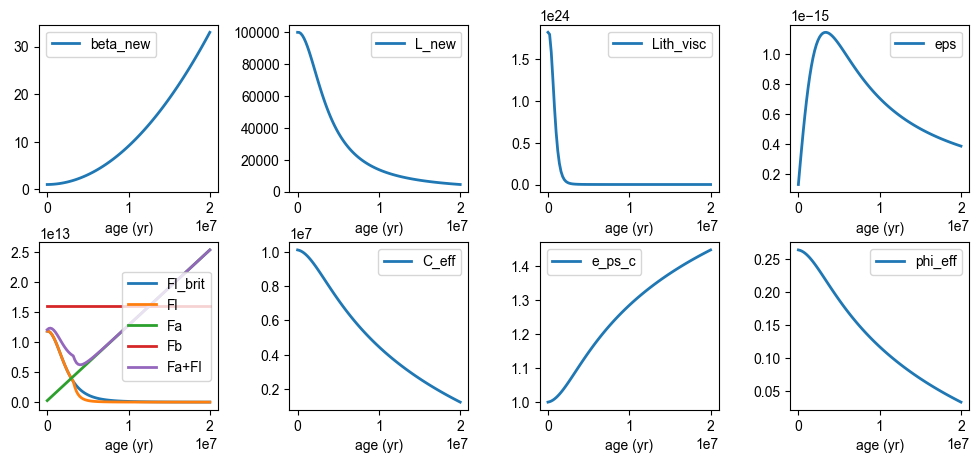

In [20]:
beta_new, L_new, Tm, lith_visc, e_ps, Fl, e_ps_cumulative, C_eff, phi_eff, Fl_visc, Fl_brit = get_Fl(v_hs,t)
Fa = get_Fa(v_hs, t)
Fb = get_Fb(v_hs, t)

fig, ax = plt.subplots(2, 4, figsize=(12, 5))
# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.3) 

ax[0,0].plot( t * sec_in_yr, beta_new, label='beta_new')
ax[0,0].set_xlabel('age (yr)')
ax[0,0].legend()
ax[0,1].plot( t * sec_in_yr, L_new, label='L_new')
ax[0,1].set_xlabel('age (yr)')
ax[0,1].legend()
ax[0,2].plot( t * sec_in_yr, lith_visc, label='Lith_visc')
ax[0,2].set_xlabel('age (yr)')
ax[0,2].legend()
ax[0,3].plot( t * sec_in_yr, e_ps, label='eps')
ax[0,3].set_xlabel('age (yr)')
ax[0,3].legend()
# ax[1,0].plot( t * sec_in_yr, Fl_visc, label='Fl_visc')
ax[1,0].plot( t * sec_in_yr, Fl_brit, label='Fl_brit')
ax[1,0].plot( t * sec_in_yr, Fl, label='Fl')
ax[1,0].plot( t * sec_in_yr, Fa, label='Fa')
ax[1,0].plot( t * sec_in_yr, Fb, label='Fb')
ax[1,0].plot( t * sec_in_yr, Fa+Fl, label='Fa+Fl')
ax[1,0].set_xlabel('age (yr)')
ax[1,0].legend()
ax[1,1].plot( t * sec_in_yr, C_eff, label='C_eff')
ax[1,1].set_xlabel('age (yr)')
ax[1,1].legend()
ax[1,2].plot( t * sec_in_yr, e_ps_cumulative, label='e_ps_c')
ax[1,2].set_xlabel('age (yr)')
ax[1,2].legend()
ax[1,3].plot( t * sec_in_yr, phi_eff, label='phi_eff')
ax[1,3].set_xlabel('age (yr)')
ax[1,3].legend()

In [21]:
def get_force_sum(V_hs, time):
    Fb = get_Fb( V_hs, time )
    Fa = get_Fa( V_hs, time )
    Fl = get_Fl( V_hs, time )[5]

    return Fb - (Fa + Fl)

def get_eps_L(V_hs, time):
    return get_Fl( V_hs, time )[6]

def get_forces(V_hs, time):
    Fb = get_Fb( V_hs, time )
    Fa = get_Fa( V_hs, time )
    beta_new, L_new, Tm, lith_visc, Fl = get_Fl( V_hs, time )
    
    return beta_new, L_new, Tm, lith_visc, Fb, Fa, Fl

def get_time_dependent_force_sum(V_hs, time):
    Fb = get_time_dependent_Fb( time )
    Fa = get_Fa( V_hs, time )
    Fl = get_Fl( V_hs, time )[5]

    return Fb - (Fa + Fl)

def get_time_dependent_forces(V_hs, time):
    Fb = get_time_dependent_Fb( time )
    Fa = get_Fa( V_hs, time )
    beta_new, L_new, Tm, lith_visc, Fl = get_Fl( V_hs, time )
    
    return beta_new, L_new, Tm, lith_visc, Fb, Fa, Fl

In [22]:

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] + plt.rcParams['font.sans-serif']
plt.rcParams['lines.linewidth'] = 2
plt.rcParams["font.weight"] = "regular"
plt.rcParams["axes.labelweight"] = "regular"
font1 = {'size': 18, 'weight': 'regular', 'color': 'black'}


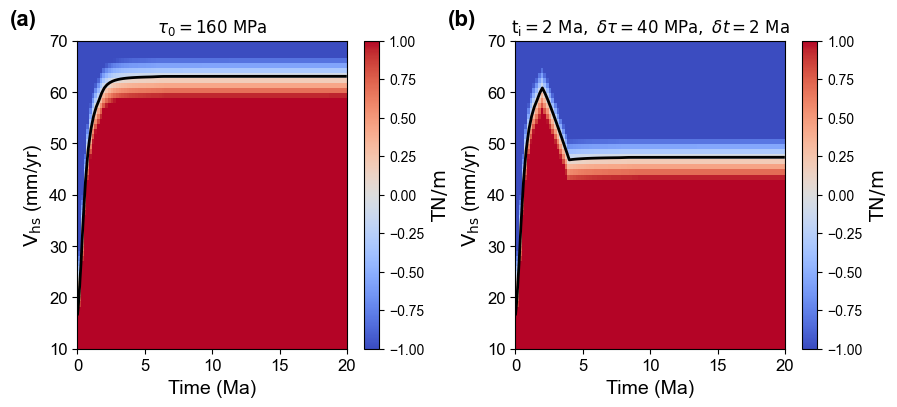

In [33]:

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[1].tick_params(axis='x', labelsize=12)
ax[1].tick_params(axis='y', labelsize=12)
ax[0].tick_params(axis='x', labelsize=12)
ax[0].tick_params(axis='y', labelsize=12)
X, Y = np.meshgrid(t, v_hs)
plt.subplots_adjust(wspace=0.3, hspace=0.3) 
obj = ax[0].pcolor(X * sec_in_yr/1e6, Y * yr_in_sec*1e3, get_force_sum(Y, X)/1e12, vmin=-1, vmax=1, cmap='coolwarm')
ax[0].contour(X * sec_in_yr/1e6, Y * yr_in_sec*1e3, get_force_sum(Y, X), levels=[0], colors='k')
ax[0].set_xlabel('Time (Ma)',fontsize=14)
ax[0].set_ylabel(r'$\mathrm{V}_{\mathrm{hs}}$ (mm/yr)', fontsize=14)
ax[0].set_title('$\u03C4_{0}= 160\ \mathrm{MPa}$',fontsize =12)
ax[0].annotate("(a)", xy=(-0.25,1.05), xycoords="axes fraction", fontsize=16, fontweight="bold")
#fig.colorbar(obj)
fig.colorbar(obj).set_label('$\mathrm{TN}/ \\mathrm{m}$', fontsize=14)
ax[0].set_xlim([0,20])
ax[0].set_ylim([10,70])
obj = ax[1].pcolor(X * sec_in_yr/1e6, Y * yr_in_sec*1e3, get_time_dependent_force_sum(Y, X)/1e12, vmin=-1, vmax=1, cmap='coolwarm')
ax[1].contour(X * sec_in_yr/1e6, Y * yr_in_sec*1e3, get_time_dependent_force_sum(Y, X), levels=[0], colors='k')
ax[1].annotate("(b)", xy=(-0.25,1.05), xycoords="axes fraction", fontsize=16, fontweight="bold")
ax[1].set_xlabel('Time (Ma)',fontsize=14)
ax[1].set_ylabel(r'$\mathrm{V}_{\mathrm{hs}}$ (mm/yr)', fontsize=14)
ax[1].set_title(r'$\mathrm{t}_{\mathrm{i}}=2\ \mathrm{Ma},\ \delta\tau =40\ \mathrm{MPa},\ \delta t=2\ \mathrm{Ma}$', fontsize=12)

fig.colorbar(obj).set_label('$\mathrm{TN}/\mathrm{m}$', fontsize=14)
ax[1].set_xlim([0,20])
ax[1].set_ylim([10,70])
plt.savefig('A2.pdf', dpi=300, bbox_inches='tight')